# 1. Import and Install Dependencies

In [2]:
!pip install tensorflow tensorflow-gpu opencv-python mediapipe sklearn matplotlib

In [3]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

# 2. Keypoints using MP Holistic

In [4]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [5]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [6]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [7]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [8]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
    
        # Read feed
        ret, frame = cap.read()
        
        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)
    
        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()
            

In [8]:
len(results.face_landmarks.landmark)

468

In [9]:
draw_landmarks(frame, results)

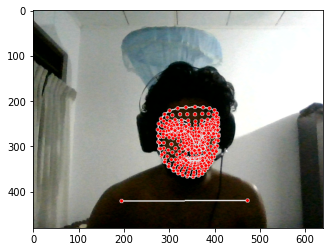

In [10]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# 3. Extract Keypoint Values

In [26]:
len(results.face_landmarks.landmark)

468

In [9]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [24]:
rh.shape

(63,)

# 4. Setup Folders for Collection

In [10]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('Action_Data') 

# Actions that we try to detect
actions = np.array(['hello', 'peace'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

# Folder start
start_folder = 30

In [20]:
for action in actions: 
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

# 5. Collect Keypoint Values for Training and Testing

In [21]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(500)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

cap.release()
cv2.destroyAllWindows()

# 6. Preprocess Data and Create Labels and Features

In [11]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [12]:
label_map = {label:num for num, label in enumerate(actions)}

In [13]:
label_map

{'hello': 0, 'peace': 1}

In [14]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [30]:
np.array(sequences).shape

(60, 30, 1662)

In [31]:
np.array(labels).shape

(60,)

In [15]:
X = np.array(sequences)

In [16]:
X.shape

(60, 30, 1662)

In [17]:
y = to_categorical(labels).astype(int)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [19]:
X_train.shape

(57, 30, 1662)

# 7. Build and Train LSTM Neural Network

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [21]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [22]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [23]:
res = [.7,0.2, 0.1]

In [24]:
actions[np.argmax(res)]

'hello'

In [25]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [44]:
model.fit(X_train, y_train, epochs=5000, callbacks=[tb_callback])

Epoch 1/5000
2/2 [==============================] - 0s 250ms/step - loss: 0.6760 - categorical_accuracy: 0.5263
Epoch 2/5000
2/2 [==============================] - 0s 76ms/step - loss: 0.6762 - categorical_accuracy: 0.5088
Epoch 3/5000
2/2 [==============================] - 0s 91ms/step - loss: 0.6804 - categorical_accuracy: 0.6491
Epoch 4/5000
2/2 [==============================] - 0s 78ms/step - loss: 0.6757 - categorical_accuracy: 0.6842
Epoch 5/5000
2/2 [==============================] - 0s 83ms/step - loss: 0.6701 - categorical_accuracy: 0.6842
Epoch 6/5000
2/2 [==============================] - 0s 89ms/step - loss: 0.6717 - categorical_accuracy: 0.5088
Epoch 7/5000
2/2 [==============================] - 0s 81ms/step - loss: 0.6716 - categorical_accuracy: 0.5789
Epoch 8/5000
2/2 [==============================] - 0s 80ms/step - loss: 0.6829 - categorical_accuracy: 0.5439
Epoch 9/5000
2/2 [==============================] - 0s 89ms/step - loss: 0.6663 - categorical_accuracy: 0.7018


2/2 [==============================] - 0s 75ms/step - loss: 0.5969 - categorical_accuracy: 0.6842
Epoch 75/5000
2/2 [==============================] - 0s 83ms/step - loss: 0.6018 - categorical_accuracy: 0.6140
Epoch 76/5000
2/2 [==============================] - 0s 72ms/step - loss: 0.5857 - categorical_accuracy: 0.7368
Epoch 77/5000
2/2 [==============================] - 0s 73ms/step - loss: 0.5956 - categorical_accuracy: 0.6842
Epoch 78/5000
2/2 [==============================] - 0s 85ms/step - loss: 0.5833 - categorical_accuracy: 0.6667
Epoch 79/5000
2/2 [==============================] - 0s 71ms/step - loss: 0.5759 - categorical_accuracy: 0.7018
Epoch 80/5000
2/2 [==============================] - 0s 77ms/step - loss: 0.5792 - categorical_accuracy: 0.7018
Epoch 81/5000
2/2 [==============================] - 0s 73ms/step - loss: 0.5716 - categorical_accuracy: 0.6316
Epoch 82/5000
2/2 [==============================] - 0s 90ms/step - loss: 0.6043 - categorical_accuracy: 0.6667
Epoch 

2/2 [==============================] - 0s 81ms/step - loss: 0.5585 - categorical_accuracy: 0.6316
Epoch 219/5000
2/2 [==============================] - 0s 79ms/step - loss: 0.6388 - categorical_accuracy: 0.5614
Epoch 220/5000
2/2 [==============================] - 0s 75ms/step - loss: 0.5762 - categorical_accuracy: 0.6667
Epoch 221/5000
2/2 [==============================] - 0s 77ms/step - loss: 0.6090 - categorical_accuracy: 0.6491
Epoch 222/5000
2/2 [==============================] - 0s 77ms/step - loss: 0.5355 - categorical_accuracy: 0.6491
Epoch 223/5000
2/2 [==============================] - 0s 81ms/step - loss: 0.6014 - categorical_accuracy: 0.5965
Epoch 224/5000
2/2 [==============================] - 0s 94ms/step - loss: 0.5424 - categorical_accuracy: 0.6491
Epoch 225/5000
2/2 [==============================] - 0s 86ms/step - loss: 0.5276 - categorical_accuracy: 0.6316
Epoch 226/5000
2/2 [==============================] - 0s 75ms/step - loss: 0.5143 - categorical_accuracy: 0.684

2/2 [==============================] - 0s 77ms/step - loss: 0.5805 - categorical_accuracy: 0.5965
Epoch 363/5000
2/2 [==============================] - 0s 85ms/step - loss: 0.5648 - categorical_accuracy: 0.6316
Epoch 364/5000
2/2 [==============================] - 0s 71ms/step - loss: 0.6214 - categorical_accuracy: 0.5789
Epoch 365/5000
2/2 [==============================] - 0s 73ms/step - loss: 0.5708 - categorical_accuracy: 0.6491
Epoch 366/5000
2/2 [==============================] - 0s 79ms/step - loss: 0.5846 - categorical_accuracy: 0.6140
Epoch 367/5000
2/2 [==============================] - 0s 125ms/step - loss: 0.5657 - categorical_accuracy: 0.6491
Epoch 368/5000
2/2 [==============================] - 0s 106ms/step - loss: 0.5061 - categorical_accuracy: 0.6842
Epoch 369/5000
2/2 [==============================] - 0s 74ms/step - loss: 0.6322 - categorical_accuracy: 0.5965
Epoch 370/5000
2/2 [==============================] - 0s 80ms/step - loss: 0.5386 - categorical_accuracy: 0.6

2/2 [==============================] - 0s 77ms/step - loss: 0.4871 - categorical_accuracy: 0.6667
Epoch 507/5000
2/2 [==============================] - 0s 73ms/step - loss: 0.5155 - categorical_accuracy: 0.6667
Epoch 508/5000
2/2 [==============================] - 0s 72ms/step - loss: 0.4811 - categorical_accuracy: 0.7193
Epoch 509/5000
2/2 [==============================] - 0s 92ms/step - loss: 0.4808 - categorical_accuracy: 0.7193
Epoch 510/5000
2/2 [==============================] - 0s 87ms/step - loss: 0.5254 - categorical_accuracy: 0.6842
Epoch 511/5000
2/2 [==============================] - 0s 80ms/step - loss: 0.5816 - categorical_accuracy: 0.6491
Epoch 512/5000
2/2 [==============================] - 0s 76ms/step - loss: 0.5687 - categorical_accuracy: 0.6667
Epoch 513/5000
2/2 [==============================] - 0s 72ms/step - loss: 0.6825 - categorical_accuracy: 0.5965
Epoch 514/5000
2/2 [==============================] - 0s 72ms/step - loss: 0.6409 - categorical_accuracy: 0.631

2/2 [==============================] - 0s 81ms/step - loss: 0.5804 - categorical_accuracy: 0.6140
Epoch 651/5000
2/2 [==============================] - 0s 84ms/step - loss: 0.5260 - categorical_accuracy: 0.6667
Epoch 652/5000
2/2 [==============================] - 0s 74ms/step - loss: 0.4901 - categorical_accuracy: 0.7544
Epoch 653/5000
2/2 [==============================] - 0s 75ms/step - loss: 0.5250 - categorical_accuracy: 0.7018
Epoch 654/5000
2/2 [==============================] - 0s 80ms/step - loss: 0.4914 - categorical_accuracy: 0.6316
Epoch 655/5000
2/2 [==============================] - 0s 73ms/step - loss: 0.5270 - categorical_accuracy: 0.7018
Epoch 656/5000
2/2 [==============================] - 0s 72ms/step - loss: 0.5180 - categorical_accuracy: 0.7018
Epoch 657/5000
2/2 [==============================] - 0s 71ms/step - loss: 0.5099 - categorical_accuracy: 0.7018
Epoch 658/5000
2/2 [==============================] - 0s 74ms/step - loss: 0.4917 - categorical_accuracy: 0.719

2/2 [==============================] - 0s 78ms/step - loss: 0.4933 - categorical_accuracy: 0.6667
Epoch 795/5000
2/2 [==============================] - 0s 89ms/step - loss: 0.4613 - categorical_accuracy: 0.7018
Epoch 796/5000
2/2 [==============================] - 0s 83ms/step - loss: 0.4881 - categorical_accuracy: 0.7544
Epoch 797/5000
2/2 [==============================] - 0s 83ms/step - loss: 0.4875 - categorical_accuracy: 0.7368
Epoch 798/5000
2/2 [==============================] - 0s 73ms/step - loss: 0.4537 - categorical_accuracy: 0.7368
Epoch 799/5000
2/2 [==============================] - 0s 74ms/step - loss: 0.5187 - categorical_accuracy: 0.7193
Epoch 800/5000
2/2 [==============================] - 0s 73ms/step - loss: 0.4429 - categorical_accuracy: 0.7719
Epoch 801/5000
2/2 [==============================] - 0s 76ms/step - loss: 0.4511 - categorical_accuracy: 0.7018
Epoch 802/5000
2/2 [==============================] - 0s 77ms/step - loss: 0.4939 - categorical_accuracy: 0.701

2/2 [==============================] - 0s 76ms/step - loss: 0.4807 - categorical_accuracy: 0.7018
Epoch 939/5000
2/2 [==============================] - 0s 74ms/step - loss: 0.5382 - categorical_accuracy: 0.7018
Epoch 940/5000
2/2 [==============================] - 0s 76ms/step - loss: 0.4441 - categorical_accuracy: 0.7544
Epoch 941/5000
2/2 [==============================] - 0s 75ms/step - loss: 0.7341 - categorical_accuracy: 0.6842
Epoch 942/5000
2/2 [==============================] - 0s 79ms/step - loss: 0.5817 - categorical_accuracy: 0.6842
Epoch 943/5000
2/2 [==============================] - 0s 77ms/step - loss: 0.5717 - categorical_accuracy: 0.6667
Epoch 944/5000
2/2 [==============================] - 0s 70ms/step - loss: 0.5833 - categorical_accuracy: 0.7368
Epoch 945/5000
2/2 [==============================] - 0s 72ms/step - loss: 0.4960 - categorical_accuracy: 0.7018
Epoch 946/5000
2/2 [==============================] - 0s 69ms/step - loss: 0.6013 - categorical_accuracy: 0.631

2/2 [==============================] - 0s 80ms/step - loss: 0.3930 - categorical_accuracy: 0.8421
Epoch 1083/5000
2/2 [==============================] - 0s 76ms/step - loss: 0.5200 - categorical_accuracy: 0.7368
Epoch 1084/5000
2/2 [==============================] - ETA: 0s - loss: 0.4572 - categorical_accuracy: 0.75 - 0s 81ms/step - loss: 0.4572 - categorical_accuracy: 0.7544
Epoch 1085/5000
2/2 [==============================] - 0s 79ms/step - loss: 0.5461 - categorical_accuracy: 0.6667
Epoch 1086/5000
2/2 [==============================] - 0s 75ms/step - loss: 0.5009 - categorical_accuracy: 0.7368
Epoch 1087/5000
2/2 [==============================] - 0s 86ms/step - loss: 0.5792 - categorical_accuracy: 0.5965
Epoch 1088/5000
2/2 [==============================] - 0s 75ms/step - loss: 0.4503 - categorical_accuracy: 0.7368
Epoch 1089/5000
2/2 [==============================] - 0s 73ms/step - loss: 0.5721 - categorical_accuracy: 0.7193
Epoch 1090/5000
2/2 [=============================

2/2 [==============================] - 0s 89ms/step - loss: 0.2864 - categorical_accuracy: 0.8772
Epoch 1154/5000
2/2 [==============================] - 0s 71ms/step - loss: 0.2580 - categorical_accuracy: 0.8772
Epoch 1155/5000
2/2 [==============================] - 0s 82ms/step - loss: 0.2529 - categorical_accuracy: 0.8947
Epoch 1156/5000
2/2 [==============================] - 0s 95ms/step - loss: 0.3644 - categorical_accuracy: 0.7895
Epoch 1157/5000
2/2 [==============================] - 0s 88ms/step - loss: 0.2984 - categorical_accuracy: 0.8596
Epoch 1158/5000
2/2 [==============================] - 0s 79ms/step - loss: 0.2291 - categorical_accuracy: 0.8947
Epoch 1159/5000
2/2 [==============================] - 0s 72ms/step - loss: 0.3021 - categorical_accuracy: 0.8772
Epoch 1160/5000
2/2 [==============================] - 0s 93ms/step - loss: 0.3652 - categorical_accuracy: 0.8070
Epoch 1161/5000
2/2 [==============================] - 0s 118ms/step - loss: 0.3886 - categorical_accura

2/2 [==============================] - 0s 117ms/step - loss: 0.1744 - categorical_accuracy: 0.9298
Epoch 1296/5000
2/2 [==============================] - 0s 114ms/step - loss: 0.1555 - categorical_accuracy: 0.9298
Epoch 1297/5000
2/2 [==============================] - 0s 103ms/step - loss: 0.1544 - categorical_accuracy: 0.9649
Epoch 1298/5000
2/2 [==============================] - 0s 96ms/step - loss: 0.1362 - categorical_accuracy: 0.9649
Epoch 1299/5000
2/2 [==============================] - 0s 111ms/step - loss: 0.1693 - categorical_accuracy: 0.9123
Epoch 1300/5000
2/2 [==============================] - 0s 117ms/step - loss: 0.1489 - categorical_accuracy: 0.9474
Epoch 1301/5000
2/2 [==============================] - 0s 102ms/step - loss: 0.1469 - categorical_accuracy: 0.9474
Epoch 1302/5000
2/2 [==============================] - 0s 90ms/step - loss: 0.2281 - categorical_accuracy: 0.8947
Epoch 1303/5000
2/2 [==============================] - 0s 77ms/step - loss: 0.1402 - categorical_a

KeyboardInterrupt: 

In [72]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 64)            442112    
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 128)           98816     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
Total params: 596,642
Trainable params: 596,642
Non-trainable params: 0
__________________________________________________

# 8. Make Predictions

In [45]:
res = model.predict(X_test)

In [27]:
actions[np.argmax(res[0])]

'hello'

In [28]:
actions[np.argmax(y_test[0])]

'hello'

# 9. Save Weights

In [92]:
model.save('action.h5')

In [93]:
del model

In [18]:
model.load_weights('action.h5')

# 10. Evaluation using Confusion Matrix and Accuracy

In [29]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [46]:
yhat = model.predict(X_train)

In [47]:
ytrue = np.argmax(y_train, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [48]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[27,  2],
        [ 0, 28]],

       [[28,  0],
        [ 2, 27]]], dtype=int64)

In [49]:
accuracy_score(ytrue, yhat)

0.9649122807017544

# 11. Test in Real Time

In [34]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [53]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
    
        # Read feed
        ret, frame = cap.read()
        
        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        #sequence.insert(0,keypoints)
        #sequence = sequence[:30]
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

             # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)
    
        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'

In [35]:
cap.release()
cv2.destroyAllWindows()